# Pravděpodobnost a statistika – zápočtový úkol

**Autor:** Janek Hlavatý

---

## Cíl práce

Cílem statistické práce je prozkoumat různé hypotézy o délce řetězců typu „xd, xdd, xddd“ v textových zprávách v chatovací aplikaci Telegram.

## Původ dat

Data byla exportována z aplikace Telegram do formátu JSON. Obsahují všechny zprávy mé i mých známých z osobních konverzací a skupinových chatů.
Z důvodu ochrany soukromí data neposkytuji přímo. Pomocí skriptu `chatProcess.py` byly spočítány délky řetězců „xd“ a výsledky byly uloženy do souboru `data/messages.csv`.

U každé zprávy je evidován její čas odeslání, autor, počet znaků „d“ a informace o tom, zda byla zpráva poslána do skupiny, či do soukromého chatu. Vedle souboru existuje také mapování z ID uživatele na jeho jméno.

---

## Předzpracování dat

- Data zahrnují všechny moje chaty i skupiny.
- Moje účast v datech může představovat zkreslení, protože s každým uživatelem sdílím zprávy jak v soukromém chatu, tak ve skupinách. Proto uvádím výsledky **včetně mých zpráv** i **bez nich**.
- Řetězce „xd“ byly vyhodnocovány **bez ohledu na velikost písmen**.
- Počítán byl pouze počet znaků „d“, znak „x“ byl ignorován.

---

## 1. hypotéza - geometrické rozdělení

**Nulová hypotéza (H0):**
Počet d má geometrické rozdělení s parametrem $p$.

Parametr $p$ byl odhadnut metodou maximální věrohodnosti:  

$$\hat{p} = \frac{1}{\bar{X}}$$

kde $\bar{X}$ je průměrná hodnota počtu d.

Pro test dobré shody byl použit chí-kvadrát test.  
Byly porovnány pozorované četnosti s očekávanými hodnotami podle geometrického rozdělení.  
Malé očekávané četnosti byly sloučeny do společné kategorie.

Testovací statistika:

$$ \chi^2 = \sum \frac{(O_i - E_i)^2}{E_i} $$

s počtem stupňů volnosti $ df = k - 1 - 1 $, kde $k$ je počet kategorií po sloučení.
Dále byl dopočítán interval spolehlivosti pro parametr $p$.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_and_test(filter=False):
    # load data
    messages = pd.read_csv("data/messages.csv")
    users = pd.read_csv("data/users.csv")

    # merge messages with users to get names
    messages = messages.merge(users, left_on="user_id", right_on="user_id", how="left")

    # filter out me
    if filter:
        messages_filtered = messages[messages["name"] != "Janek Hlavatý"]
    else:
        messages_filtered = messages
    k = messages_filtered["Damount"].astype(int).to_numpy()
    k = k[k >= 1]
    n = len(k)

    # p_hat is guess
    kbar = k.mean()
    p_hat = 1.0 / kbar
    print("Počet pozorování n =", n)
    print("Průměrná hodnota =", kbar)
    print("Odhad parametru p =", p_hat)

    # observed
    obs_counts = np.bincount(k)[1:]  # we start from 1
    vals = np.arange(1, len(obs_counts)+1)

    # expected
    probs = p_hat * (1 - p_hat) ** (vals - 1)
    exp_counts = n * probs

    # join small categories
    obs_binned = []
    exp_binned = []
    labels = []

    # cumulative observed and expected values
    cum_obs = 0
    cum_exp = 0
    for v, obs, exp in zip(vals, obs_counts, exp_counts):
        cum_obs += obs
        cum_exp += exp
        if cum_exp >= 5:
            obs_binned.append(cum_obs)
            exp_binned.append(cum_exp)
            labels.append(str(v))
            cum_obs, cum_exp = 0, 0

    if cum_exp > 0:
        obs_binned[-1] += cum_obs
        exp_binned[-1] += cum_exp
        labels[-1] = labels[-1] + "+"

    obs_binned = np.array(obs_binned)
    exp_binned = np.array(exp_binned)

    # 6. Chí-kvadrát test
    chi2 = np.sum((obs_binned - exp_binned)**2 / exp_binned)
    df_chi = len(obs_binned) - 1 - 1  # -1 za součet, -1 za odhad p
    p_value = 1 - stats.chi2.cdf(chi2, df_chi)

    print("\nTabulka (po sloučení kategorií):")
    for l, o, e in zip(labels, obs_binned, exp_binned):
        print(f"{l}: observed={o}, expected={e:.2f}")

    print("\nChi2 =", chi2, " df =", df_chi, " p-value =", p_value)

    # 7. CI for p
    # E[K] = 1/p, Var[K] = (1-p)/p^2
    var_k = (1 - p_hat) / (p_hat**2)
    se_mean = np.sqrt(var_k / n)

    alpha = 0.05
    z = stats.norm.ppf(1 - alpha/2)
    ci_mean = (kbar - z*se_mean, kbar + z*se_mean)
    ci_p = (1/ci_mean[1], 1/ci_mean[0])

    print("\n95% CI pro průměr =", ci_mean)
    print("95% CI pro p =", ci_p)

    # plot

    plt.figure(figsize=(8,5))
    plt.bar(labels, obs_binned, alpha=0.6, label="Pozorované", color='skyblue')
    plt.plot(labels, exp_binned, 'ro', label=f"Očekávané (geom., p={p_hat})")
    plt.yscale('log')

    plt.xlabel("Počet d")
    plt.ylabel("Četnost (log)")
    if filter:
        plt.title("Rozdělení délky 'xd...d' s logaritmickou osou a CI (bez Janek Hlavatý)")
    else:
        plt.title("Rozdělení délky 'xd...d' s logaritmickou osou a CI")
    plt.legend()
    plt.show()

plot_and_test()
plot_and_test(True)


Hodnoty na ose y mají logaritmickou škálu pro jednodušší interpretaci. Z dat vidíme, že se hodnoty výrazně liší, jak u dat se mnout tak beze mě. P value = 0, hypotézu tedy zamítáme, data neodpovídají geometrickému rozdělení.

## Doplňková vizualizace – průměrná délka vs. počet zpráv

Pro ilustraci byla vykreslena závislost průměrného počtu znaků „d“ na celkovém počtu zpráv jednotlivých uživatelů.
- Nejvyšší počet zpráv vykazují **Janek Hlavatý** a **Prokop**.
- Nejvyšší průměrnou délku výrazů pak **Marian** a **Kačka** (Marek Maškarinec má nízký počet pozorování).

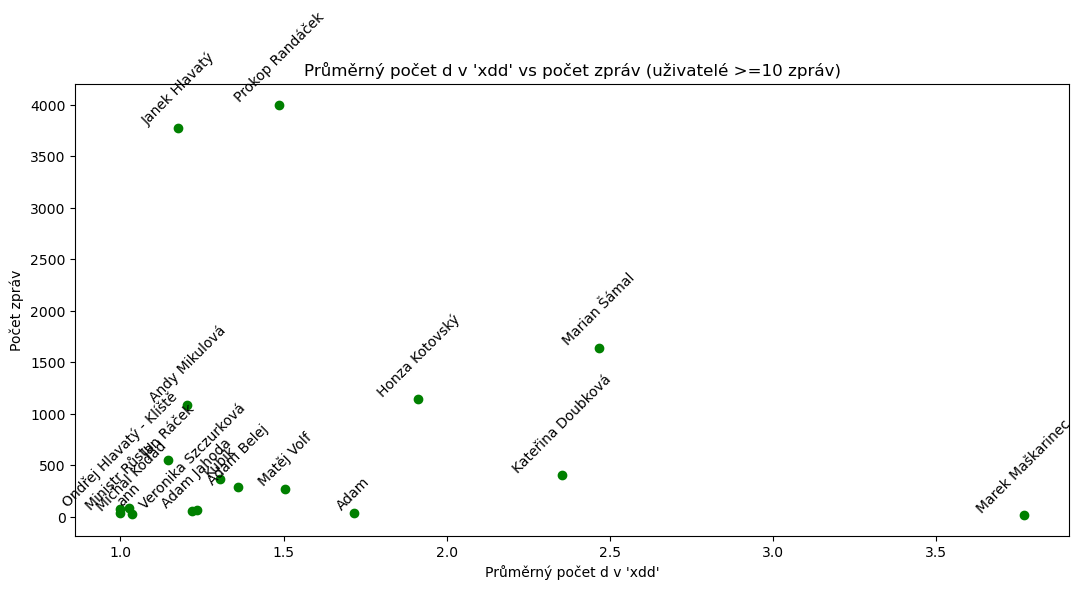

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# load data
messages = pd.read_csv("data/messages.csv")
users = pd.read_csv("data/users.csv")

df = messages.merge(users, on="user_id", how="left")

stats = (
df.groupby(["user_id", "name"])['Damount']
    .agg(["mean", "count"])
    .reset_index()
)

stats = stats[stats["count"] >= 10]

# plot
plt.figure(figsize=(11,6))
plt.scatter(stats["mean"], stats["count"], color="green")

for x, y, name in zip(stats["mean"], stats["count"], stats["name"]):
    plt.text(x, y+0.5, name, rotation=45, ha="center", va="bottom")

plt.xlabel("Průměrný počet d v 'xdd'")
plt.ylabel("Počet zpráv")
plt.title("Průměrný počet d v 'xdd' vs počet zpráv (uživatelé >=10 zpráv)")
plt.tight_layout()
plt.show()

## 2. Hypotéza – konzistence mezi skupinovými chaty a soukromými zprávami

**Cíl:** Ověřit, zda jednotliví uživatelé používají konzistentně stejný počet znaků „d“ ve výrazech „xd, xdd, xddd…“ v soukromých zprávách (DMs) a ve skupinových konverzacích.

**Nulová hypotéza (H₀):** Rozdělení počtu znaků „d“ u konkrétního uživatele je stejné v soukromých zprávách i ve skupinových chatech.

- Použitý test: **Mann–Whitney U test**.
- Do analýzy byli zahrnuti pouze uživatelé s alespoň 50 zprávami v obou typech konverzace.

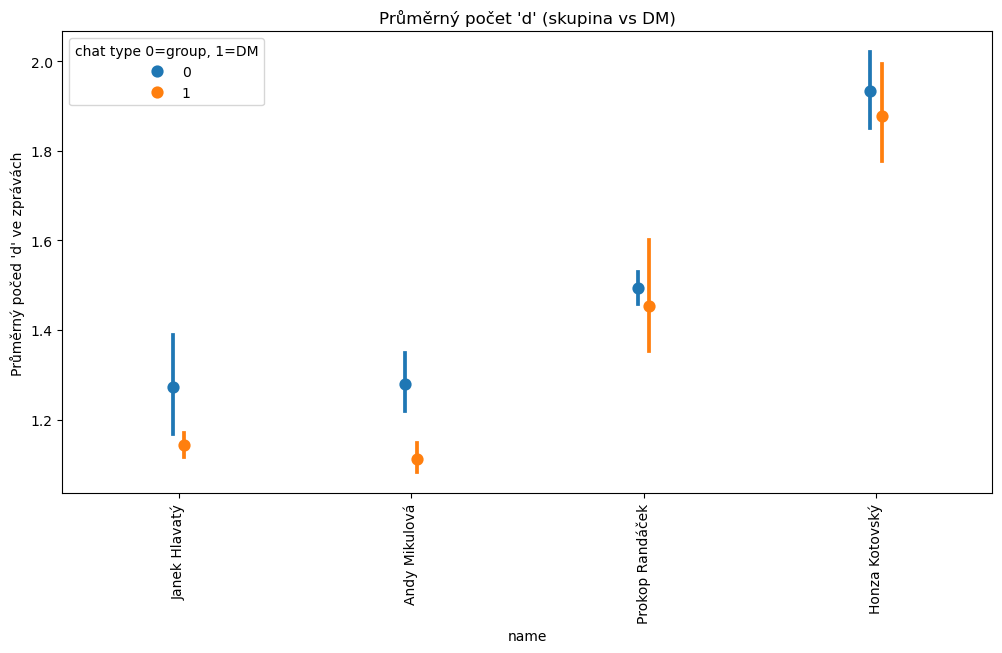

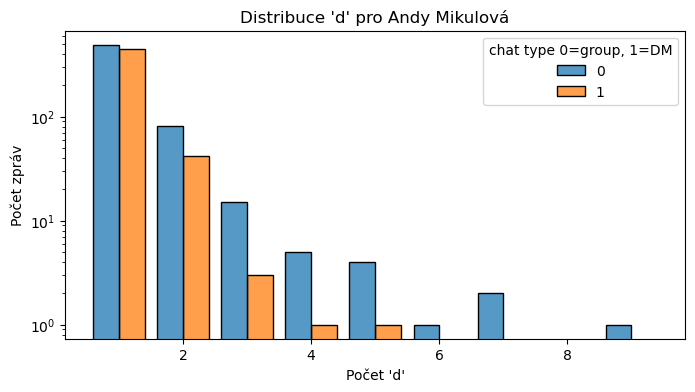

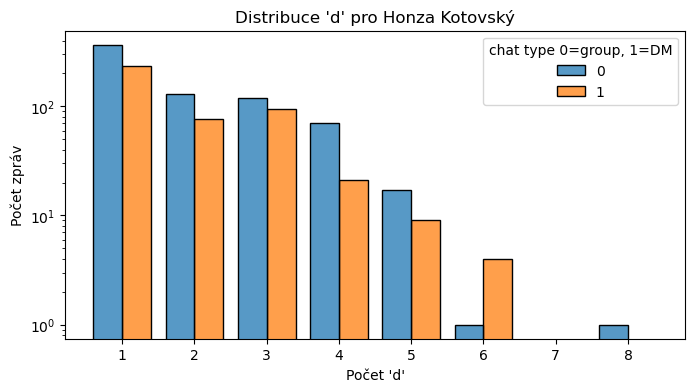

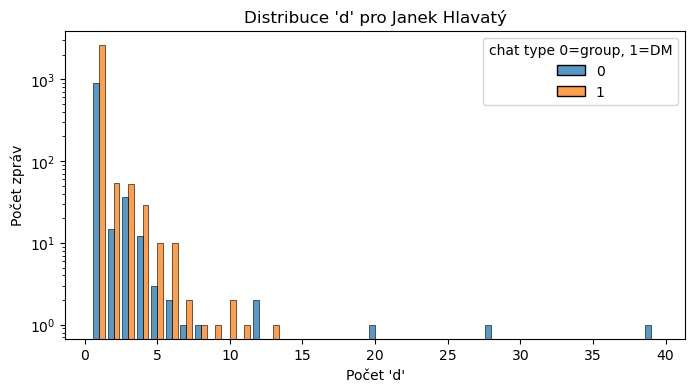

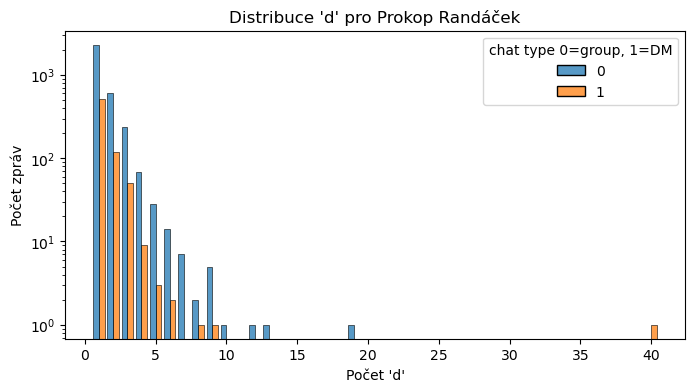

Andy Mikulová: U = 159531.00, p = 0.0000, mean group=1.28, mean DM=1.11
Honza Kotovský: U = 156543.50, p = 0.5066, mean group=1.93, mean DM=1.88
Janek Hlavatý: U = 1388311.50, p = 0.0293, mean group=1.27, mean DM=1.14
Prokop Randáček: U = 1206998.50, p = 0.0469, mean group=1.49, mean DM=1.45


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

messages = pd.read_csv("data/messages.csv")
users = pd.read_csv("data/users.csv")
df = messages.merge(users, on="user_id", how="left")

# filter users with >=50 messages
counts = df.groupby(["user_id", "chat type 0=group, 1=DM"]).size().unstack(fill_value=0)
valid_users = counts[(counts[0] >= 50) & (counts[1] >= 50)].index
df = df[df["user_id"].isin(valid_users)]

# plot
plt.figure(figsize=(12,6))
sns.pointplot(
    data=df,
    x="name",
    y="Damount",
    hue="chat type 0=group, 1=DM",
    dodge=True,
    errorbar=('ci', 95),
    linestyle='none',
    markers="o"
)
plt.ylabel("Průměrný počed 'd' ve zprávách")
plt.title("Průměrný počet 'd' (skupina vs DM)")
plt.xticks(rotation=90)
plt.show()

# histograms for each user
for user in valid_users:
    name = df.loc[df["user_id"] == user, "name"].iloc[0]
    
    plt.figure(figsize=(8,4))
    sns.histplot(
        data=df[df["user_id"] == user],
        x="Damount",
        hue="chat type 0=group, 1=DM",
        multiple="dodge",
        shrink=0.8,
        discrete=True
    )
    plt.title(f"Distribuce 'd' pro {name}")
    plt.xlabel("Počet 'd'")
    plt.ylabel("Počet zpráv")
    plt.yscale('log')
    plt.show()

for user in valid_users:
    name = df.loc[df["user_id"] == user, "name"].iloc[0]

    # Mann–Whitney U test
    group = df[(df["user_id"] == user) & (df["chat type 0=group, 1=DM"] == 0)]["Damount"]
    dm    = df[(df["user_id"] == user) & (df["chat type 0=group, 1=DM"] == 1)]["Damount"]

    stat, p = mannwhitneyu(group, dm, alternative="two-sided")
    print(f"{name}: U = {stat:.2f}, p = {p:.4f}, "
          f"mean group={group.mean():.2f}, mean DM={dm.mean():.2f}")

## Výsledky

- **Andy Mikulová:** rozdíl statisticky vysoce významný (U = 159 531, p < 0,001).
  Ve skupinových chatech je průměrný počet znaků „d“ vyšší (1,28) než v soukromých zprávách (1,11).

- **Honza Kotovský:** rozdíl není statisticky významný (U = 156 543,5, p = 0,507).
  Průměrné hodnoty jsou velmi podobné (skupiny 1,93; soukromé 1,88).

- **Janek Hlavatý:** rozdíl statisticky významný (U = 1 388 311,5, p = 0,029).
  Ve skupinových chatech je průměrný počet znaků „d“ vyšší (1,27) oproti soukromým zprávám (1,14).

- **Prokop Randáček:** rozdíl statisticky významný (U = 1 206 998,5, p = 0,047).
  Ve skupinových chatech je průměrný počet znaků „d“ mírně vyšší (1,49) než v soukromých zprávách (1,45).

---

## Závěr

- U tří ze čtyř analyzovaných uživatelů byl potvrzen **statisticky významný rozdíl** mezi skupinovými a soukromými zprávami.
- Ve všech případech je průměrný počet znaků „d“ vyšší ve skupinových konverzacích, což vedlo k zamítnutí nulové hypotézy.
- **Výjimkou** je Honza Kotovský, u něhož nebyl zjištěn žádný významný rozdíl, nulovou hypotézu tedy přijímáme.

**Celkově výsledky naznačují, že uživatelé mají tendenci prodlužovat výraz „xd“ více ve skupinových konverzacích než v soukromých zprávách.**